In [1]:
import numpy as np
import math
import matplotlib as plt
import networkx as nx

%matplotlib inline

# Ring of polynomials for the weights of the base
R.<k> = PolynomialRing(QQ)

# Ring of polynomials in a whose coefficients are rational functions in k
S.<a> = PolynomialRing(FractionField(R))

def sturm(p):
    """
        Computes the Sturm polynomials.
        
        Args:
            p: a polynomial in a with rational coefficients in k.
            
        Returns:
            the Sturm polynomials of p.
    """
    S = []
    if p == 0:
        return S
    S.append(p)
    S.append(diff(p, a))
    assert S[-2].gcd(S[-1]) == 1, S[-2].gcd(S[-1])
    while True:
        next_p = -S[-2].mod(S[-1])
        if next_p == 0:
            break
        S.append(next_p)
    return S

# Maybe there's a better way, but I couldn't find it

x = var('x')
ge_op = (x>=0).operator()
gt_op = (x>0).operator()
lt_op = (x<0).operator()

def changes(S, *points, power=1):
    """
        Computes sign changes in the Sturm polynomials in a at given points.
        
        Args:
            S: the Sturm polynomials of a polynomial in a.
            points: the points at which sign changes must be computed.
            power: replace k with x^power; by passing points expressed in
                x, rather than in k, one can effectively compute sign
                changes at points containing roots of k whose order is a 
                divisor of power.
            
        Returns:
            a dictionary mapping each point to the number of sign changes and the first valid value k for such changes.
    """

    changes={}
    for point in points:
        prev_op = None
        c = 0
        m = 0
        for i in range(len(S)):
            sol = solve(S[i](a=point)(k=x^power)>0,x)
            op = '+'
            if len(sol) > 0:
                if isinstance(sol[-1], list):
                    ineq = sol[-1][-1]
                    assert ineq.lhs() == x
                    if ineq.operator() != ge_op and ineq.operator() != gt_op:
                        op = '-'
                    m = max(m, ineq.rhs())
                else:
                    # Here we expect x < +Infinity
                    assert sol[-1].operator() == lt_op and sol[-1].lhs() == x and sol[-1].rhs() == +Infinity
            else:
                # Everywhere negative
                op = '-'
            if i > 0 and op != prev_op:
                c += 1
            prev_op = op
        
        # Now we try to improve m manually
            
        for r in range(math.ceil(m) - 1, 0, -1):
            prev_op = '0'
            d = 0
            for i in range(len(S)):
                if S[i].denominator()(a=point)(k=r) == 0:
                    d = -1
                    break
                v = S[i](a=point)(k=r)
                if v == 0:
                    op = '0'
                elif v > 0:
                    op = '+'
                else:
                    op = '-'
                if op != prev_op and op != '0' and prev_op != '0':
                    d += 1
                prev_op = op
                
            if d == c:
                m = m -1
            else:
                break
        
        changes[point] = [c, m^power]
        
    return changes 


def printChanges(changes, l, r):
    """
        Prints (in an easy-to-read way) the number of changes of a function in a given interval (l..r].
        
        Args:
            changes: the result of changes(S,l,r).
            l: the left estreme passed to changes().
            r: the right extreme passed to changes().
    """
    bound = max(changes[l][1], changes[r][1])
    print("Number of zeros for " , l, " < ⍺ ≤ ", r, ": ", changes[l][0] - changes[r][0], " for k ", ("> " if math.ceil(bound) == bound else "≥ " ), math.ceil(bound), sep = "")


def printLimits(*points):
    """
        Prints (in an easy-to-read way) the limits at infinity of the arguments.
    """
    for point in points:
        print(point, "→", limit(point, k=infinity), "for k → ∞")


def lower_bound(solve_res):
    """
        Returns the very last inequality of a solve() result, given that is a lower bound
        (an assertion will fail otherwise), rounding to the next integer.
        
        Args:
            solve_res: the result of solve().
            
        Returns:
            a string given by "> C" or "≥ C", where C is the lower bound.
    """
    t = solve_res[-1][-1]
    operator = t.operator()
    operands = t.operands()
    assert operator == gt_op or operator == ge_op
    bound = math.ceil(operands[1])
    if operator == gt_op and bound == operands[1]:
        return "≥ " + str(bound + 1)
    else:
        return "≥ " + str(bound)


# Counterexample

In [2]:
# Rank monotonicity counterexample
# Node names correspond to the labeling in the paper


A_pre  = matrix(7, 7, [
    0, 0, 0, 1, 1, 0, 0,
    0, 0, 1, 0, 0, 1, 0,
    0, 1, 0, 1, 0, 0, 1,
    1, 0, 1, 0, 0, 0, 0,
    k, 0, 0, 0, k-1, 0, 0,
    0, (k-1)*(k-2), 0, 0, 0, 0, 0,
    0, 0, k, 0, 0, 0, k-1
])

A_post  = matrix(7, 7, [
    0, 1, 0, 1, 1, 0, 0,
    1, 0, 1, 0, 0, 1, 0,
    0, 1, 0, 1, 0, 0, 1,
    1, 0, 1, 0, 0, 0, 0,
    k, 0, 0, 0, k-1, 0, 0,
    0, (k-1)*(k-2), 0, 0, 0, 0, 0,
    0, 0, k, 0, 0, 0, k-1
])

# Column sums of the adjugate (AKA Katz's index multiplied by the determinant)

r_pre = vector([1]*7) * (~(identity_matrix(7) - a * A_pre) * det(identity_matrix(7) - a * A_pre))
r_post = vector([1]*7) * (~(identity_matrix(7) - a * A_post) * det(identity_matrix(7) - a * A_post))

## Dominant  Eigenvalue Bounds

The dominant eigenvalue of both matrices is sandwitched between $\mathit{lower}=k+\frac1{k^2}$ and $\mathit{upper} = k + \frac3{4k}$.

In [3]:
lower, upper = k + 1/(k*k), k+3/(4*k)
print("Pre:")
charpoly = det(A_pre - a * identity_matrix(7))
St = sturm(charpoly)
l, r = lower, upper
result = changes(St, l, r)
printChanges(result, l, r)
l, r = upper, 2*k
result = changes(St, l, r)
printChanges(result, l, r)

print()

print("Post:")
charpoly = det(A_post - a * identity_matrix(7))
St = sturm(charpoly)
l, r = lower, upper
result = changes(St, l, r)
printChanges(result, l, r)
l, r = upper, 2*k
result = changes(St, l, r)
printChanges(result, l, r)

# Determinants are positive

det_pre = det(identity_matrix(7) - a * A_pre)
det_post = det(identity_matrix(7) - a * A_post)

unused = lower_bound(solve(det_pre(a=1/upper)(k=x)>0, x))
unused = lower_bound(solve(det_post(a=1/upper)(k=x)>0, x))

Pre:
Number of zeros for (k^3 + 1)/k^2 < ⍺ ≤ (k^2 + 3/4)/k: 1 for k ≥ 4
Number of zeros for (k^2 + 3/4)/k < ⍺ ≤ 2*k: 0 for k ≥ 4

Post:
Number of zeros for (k^3 + 1)/k^2 < ⍺ ≤ (k^2 + 3/4)/k: 1 for k ≥ 24
Number of zeros for (k^2 + 3/4)/k < ⍺ ≤ 2*k: 0 for k ≥ 24


## Score Comparison

Node 1 is more important than node 0 when $\alpha = \frac1{\mathit{upper}}$ (top violation).

In [4]:
p = S(r_pre[1] - r_pre[0])

print("Node 0 is more important than node 1 when ⍺ = 2/3 for k", lower_bound(solve(p(a=1/upper)(k=x)>0, x)))

Node 0 is more important than node 1 when ⍺ = 2/3 for k ≥ 54


It is also more important when $\frac1{\mathit{upper}}<\alpha\leq \frac1{\mathit{lower}}$, which is an interval including $\frac1\rho$.

In [5]:
St = sturm(p)

l, r = 1/upper, 1/lower

printChanges(changes(St, l, r, power=2), l, r)

Number of zeros for k/(k^2 + 3/4) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 54


## Rank Counterexample

### PRE

Note 1 is more important than node 4 when $\alpha = \frac1{\mathit{upper}}$.

In [6]:
p = S(r_pre[1] - r_pre[4])

print("Node 1 is more important than node 4 when ⍺ = 1/upper for k", lower_bound(solve(p(a=1/upper)(k=x)>0,x)))

Node 1 is more important than node 4 when ⍺ = 1/upper for k ≥ 53


It is also more important when $\frac1{\mathit{upper}}<\alpha\leq \frac1{\mathit{lower}}$, which is an interval including $\frac1\rho$.

In [7]:
St = sturm(p)

l, r = 1/upper, 1/lower

printChanges(changes(St, l, r), l, r)

Number of zeros for k/(k^2 + 3/4) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 53


### POST


Node 1 is less important than node 4 when $\alpha = \frac1{\mathit{upper}}$.

In [8]:
p = S(r_post[4] - r_post[1])

print("Node 1 is less important than node 4 when ⍺ = 1/upper for k", lower_bound(solve(p(a=1/upper)(k=x)>0,x)))

Node 1 is less important than node 4 when ⍺ = 1/upper for k ≥ 3


It is also less important when $\frac1{\mathit{upper}}<\alpha\leq \frac1{\mathit{lower}}$, which is an interval including $\frac1\rho$.

In [9]:
St = sturm(p)

l, r = 1/upper, 1/lower

printChanges(changes(St, l, r), l, r)

Number of zeros for k/(k^2 + 3/4) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 1


# Statements Outside Interval of Validity

## Score Comparison

In [10]:
p = S(r_pre[1] - r_pre[0])

St = sturm(p)

l, r = 0, 1/(k+2/k)
printChanges(changes(St, l, r), l, r)

l, r = 1/(k+2/k), 1/(k+1/k)
printChanges(changes(St, l, r), l, r)

l, r = 1/(k+1/k), 1/upper
printChanges(changes(St, l, r), l, r)

Number of zeros for 0 < ⍺ ≤ k/(k^2 + 2): 1 for k ≥ 16
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k/(k^2 + 1): 1 for k ≥ 16
Number of zeros for k/(k^2 + 1) < ⍺ ≤ k/(k^2 + 3/4): 1 for k ≥ 54


## Rank Counterexample

### PRE

In [11]:
p = S(r_pre[1] - r_pre[4])

St = sturm(p)

l, r = 0, 1/(k+2/k)
printChanges(changes(St, l, r), l, r)

l, r = 1/(k+2/k), 1/(k+1/k)
printChanges(changes(St, l, r), l, r)

l, r = 1/(k+1/k), 1/upper
printChanges(changes(St, l, r), l, r)

Number of zeros for 0 < ⍺ ≤ k/(k^2 + 2): 1 for k ≥ 15
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k/(k^2 + 1): 1 for k ≥ 15
Number of zeros for k/(k^2 + 1) < ⍺ ≤ k/(k^2 + 3/4): 1 for k ≥ 53


### POST


In [12]:
p = S(r_post[4] - r_post[1])

St = sturm(p)

l, r = 0, 1/(k+2/k)
printChanges(changes(St, l, r), l, r)

l, r = 1/(k+2/k), 1/(k+1/k)
printChanges(changes(St, l, r), l, r)

l, r = 1/(k+1/k), 1/upper
printChanges(changes(St, l, r), l, r)

Number of zeros for 0 < ⍺ ≤ k/(k^2 + 2): 1 for k ≥ 4
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k/(k^2 + 1): 0 for k ≥ 4
Number of zeros for k/(k^2 + 1) < ⍺ ≤ k/(k^2 + 3/4): 0 for k ≥ 1


## Demotion when $\frac1{k+\frac2k}\leq\alpha\leq \frac1{\mathit{lower}}$

Not counting node 0 and node 4, there are two nodes more important than node 1 before adding the edge when $\alpha=\frac1{k+\frac2k}$.

In [13]:
for i in range(7):
    if i == 0 or i == 1 or i == 4:
        continue
    p = S(r_pre[i] - r_pre[1])
    if p == 0:
        print("Node", i, "has the same score of node 1")
    else:
        try:
            kmin = lower_bound(solve(p(a=1/(k+2/k))(k=x)>0,x))
            print("Node", i, "is ultimately more important than node 1 for k", kmin)
        except:
            print("Node", i, "is ultimately not more important than node 1")

Node 2 is ultimately more important than node 1 for k ≥ 1
Node 3 is ultimately not more important than node 1
Node 5 is ultimately not more important than node 1
Node 6 is ultimately more important than node 1 for k ≥ 2


Not counting node 0 and node 4, there are two nodes more important than node 1 also when $\frac1{k+\frac2k}<\alpha\leq \frac1{\mathit{lower}}$, which is an interval including $\frac1\rho$.

In [14]:
l, r = 1/(k+2/k), 1/lower

for i in range(7):
    if i == 0 or i == 1 or i == 4:
        continue
    p = S(r_pre[1] - r_pre[i])
    St = sturm(p)
    printChanges(changes(St, l, r), l, r)


Number of zeros for k/(k^2 + 2) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 4
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 15
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 3
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 3


There are four nodes more important than node 1 after adding the edge when $\alpha=\frac1{k+\frac2k}$.

In [15]:
for i in range(7):
    if i == 1:
        continue
    p = S(r_post[i] - r_post[1])
    if p == 0:
        print("Node", i, "has the same score of node 1")
    else:
        try:
            kmin = lower_bound(solve(p(a=1/(k+2/k))(k=x)>0,x))
            print("Node", i, "is ultimately more important than node 1 for k ", kmin)
        except:
            print("Node", i, "is ultimately not more important than node 1")

Node 0 is ultimately more important than node 1 for k  ≥ 1
Node 2 is ultimately more important than node 1 for k  ≥ 1
Node 3 is ultimately not more important than node 1
Node 4 is ultimately more important than node 1 for k  ≥ 4
Node 5 is ultimately not more important than node 1
Node 6 is ultimately more important than node 1 for k  ≥ 4


There are four nodes more important than node 1 also when $\frac1{k+\frac2k}<\alpha\leq \frac1{\mathit{lower}}$, which is an interval including $\frac1\rho$.

In [16]:
l, r = 1/(k+2/k), 1/lower

for i in range(7):
    if i == 1:
        continue
    p = S(r_post[i] - r_post[1])
    St = sturm(p)
    printChanges(changes(St, l, r), l, r)


Number of zeros for k/(k^2 + 2) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 4
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 4
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 3
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 4
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 3
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k^2/(k^3 + 1): 0 for k ≥ 4


## Existence of Further Regions (Top and Bottom Violations)

When $\frac1{k + \frac2k}<\alpha\leq \frac1{\mathit{upper}}$ in the original graph the relative importance of node 0 and node 1 flips twice, as well as the relative importance of node 1 and node 4. First we have the first flip of importance of node 0 and node 1, then the first flip of importance of node 1 and node 4, then the second flip of importance of node 1 and node 4, and finally the second flip of importance of node 0 and node 1.

In [17]:
p = S((r_pre[1] - r_pre[4]) - (r_pre[1] - r_pre[0]))

print("The score delta between node 1 and node 4 dominates the score delta between node 1 and node 0 when ⍺ = 1/(k+2/k) for k", lower_bound(solve(p(a=1/(k+1/k))(k=x)>0,x)))

St = sturm(p)

l, r = 1/(k+2/k), 1/upper

printChanges(changes(St, l, r), l, r)

The score delta between node 1 and node 4 dominates the score delta between node 1 and node 0 when ⍺ = 1/(k+2/k) for k ≥ 1
Number of zeros for k/(k^2 + 2) < ⍺ ≤ k/(k^2 + 3/4): 0 for k ≥ 5


# NetworkX Graphs

In [18]:
def getGH(kk):
    """
        Returns the networkx graphs of $G_k$ and $G_k'$.
        
        Args:
            the value of k
            
        Returns:
            the graph $G_k$, the graph $G_k'$ and a dictionary whose keys are the nodes of the graph and whose values
            are the node names suitable to be passed to the draw function.
    """
    labels={}
    G=nx.Graph()
    G.add_nodes_from([0,1])
    for i in range(4):
        labels[i]=i
    G.add_nodes_from([0, 1, 2, 3])
    G.add_edges_from([(0,3), (3,2), (2,1)])
    for i in range(kk):
        labels["4_{}".format(i)]=4
        labels["6_{}".format(i)]=6
        G.add_edge("4_{}".format(i),0)
        G.add_edge("6_{}".format(i),2)            
        for j in range(i+1, kk):
            G.add_edge("4_{}".format(i),"4_{}".format(j))
            G.add_edge("6_{}".format(i),"6_{}".format(j))
    for i in range((kk-1)*(kk-2)):
        labels["5_{}".format(i)]=5
        G.add_edge("5_{}".format(i),1)
    H=G.copy()
    H.add_edge(0,1,color='r')
    return G, H, labels

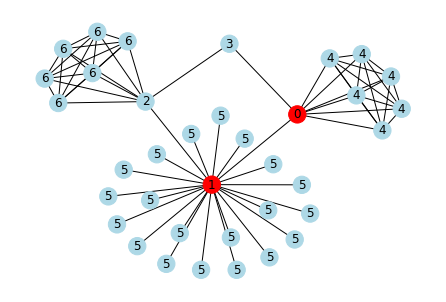

In [19]:
G,H,labels=getGH(6)
nx.draw(H, nx.kamada_kawai_layout(H), with_labels=True, labels=labels, node_color=["red"]*2+["lightblue"]*(len(H)-2))

Let's try to compute explicitly Katz's index for given values of $k$ and $\alpha$.

In [20]:
kk=8
aa=1/(kk+2/kk)+0.0
G,H,labels=getGH(kk)
c=nx.katz_centrality(G, alpha=aa, normalized=False)
cp=nx.katz_centrality(H, alpha=aa, normalized=False)
for xx in [0,1,2,3,"4_0","5_0","6_0"]:
    print("{}\t{:.4f}\t{:.4f}".format(xx, c[xx], cp[xx]))

0	40.0032	79.9977
1	34.4668	66.5525
2	58.6338	79.9977
3	12.9560	20.3934
4_0	38.6025	70.5981
5_0	5.1778	9.0670
6_0	53.5070	70.5981


Check that this is equivalent to its symbolic counterpart.

In [21]:
d=det_pre(a=aa)(k=kk)
dp=det_post(a=aa)(k=kk)
c=r_pre(a=aa)(k=kk).numpy(float)
cp=r_post(a=aa)(k=kk).numpy(float)
print("Determinant pre: {:.6f}\nDeterminant post: {:.6f}".format(d,dp))
for xx in range(7):
    print("{}\t{:.4f}\t{:.4f}".format(xx, c[xx]/d, cp[xx]/dp))

Determinant pre: 0.000313
Determinant post: 0.000233
0	40.0033	79.9978
1	34.4669	66.5526
2	58.6340	79.9978
3	12.9560	20.3934
4	38.6026	70.5983
5	5.1778	9.0670
6	53.5072	70.5983


# Numerical Examples

An example of bottom violation.

In [22]:
kk=60
aa=1/(kk+3/(4*kk))-0.0000000501
c=(r_pre/det_pre)(a=aa)(k=kk).numpy(float)
cp=(r_post/det_post)(a=aa)(k=kk).numpy(float)
for xx in [0,1,4]:
    print("{}\t{:.10f}\t{:.10f}".format(xx, c[xx], cp[xx]))

0	5102.2398538231	77021.3036440674
1	5102.1913583795	52659.1978952903
4	5097.6124264098	76116.1306403241


An example with $\alpha=\frac1{k+\frac2k}$.

In [23]:
kk=60
aa=1/(kk+2/kk)
c=(r_pre/det_pre)(a=aa)(k=kk).numpy(float)
cp=(r_post/det_post)(a=aa)(k=kk).numpy(float)
for xx in [0,1,4]:
    print("{}\t{:.10f}\t{:.10f}".format(xx, c[xx], cp[xx]))

0	1841.7374438945	3680.3539898623
1	2109.4696802355	3576.4941187448
4	1840.4233328011	3619.7296676087


An example of bottom violation in the second interval.

In [24]:
kk=60
aa=0.01666036
c=(r_pre/det_pre)(a=aa)(k=kk).numpy(float)
cp=(r_post/det_post)(a=aa)(k=kk).numpy(float)
for xx in [0,1,4]:
    print("{}\t{:.10f}\t{:.10f}".format(xx, c[xx], cp[xx]))


0	2735.5160018426	7205.8123977632
1	2735.3111274033	5942.8366701831
4	2733.4541516263	7104.4740722792


An example of top violation in the second interval.

In [25]:
kk=60
aa=0.0166602
c=(r_pre/det_pre)(a=aa)(k=kk).numpy(float)
cp=(r_post/det_post)(a=aa)(k=kk).numpy(float)
for xx in [0,1,4]:
    print("{}\t{:.10f}\t{:.10f}".format(xx, c[xx], cp[xx]))


0	2665.1459002332	6849.3992789968
1	2681.9481630747	5703.9638399318
4	2663.1472235742	6752.1710135383


# Graphics

Behavior of the relative importance of nodes 0, 1 and 4 in the whole interval $0\leq\alpha<\frac1{\rho_k'}$.

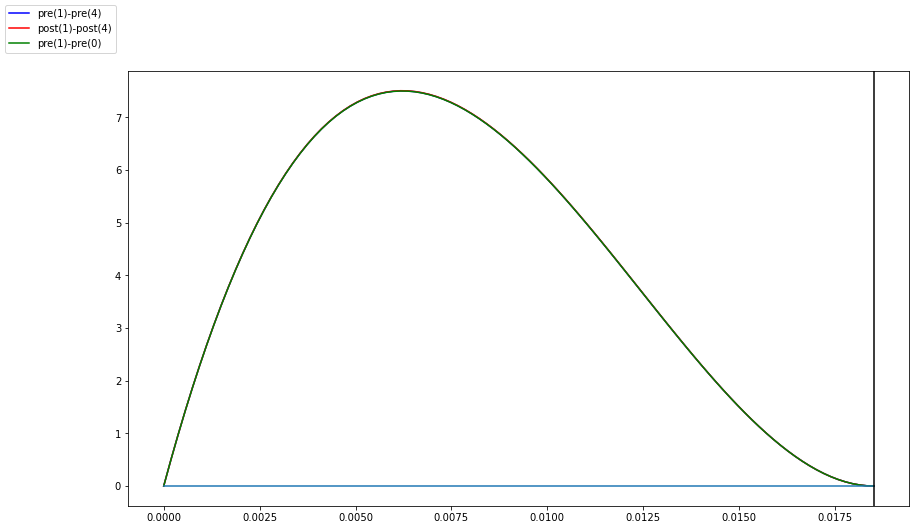

In [26]:
kk=54
rhop = max(np.linalg.eig(A_post(k=kk))[0])
xx = np.linspace(0, (1/rhop)*1.00001, 100)
yy = [r_pre[1](k=kk)(a=x) - r_pre[4](k=kk)(a=x) for x in xx]
zz = [r_post[1](k=kk)(a=x) - r_post[4](k=kk)(a=x) for x in xx]
tt = [r_pre[1](k=kk)(a=x) - r_pre[0](k=kk)(a=x) for x in xx]
fig = plt.pyplot.figure(figsize=(14,8))
plt.pyplot.plot(xx, yy, color = "blue", label = "pre(1)-pre(4)")
plt.pyplot.plot(xx, zz, color = "red", label = "post(1)-post(4)")
plt.pyplot.plot(xx, tt, color = "green", label = "pre(1)-pre(0)")
plt.pyplot.plot(xx, [0]*len(xx))
plt.pyplot.axvline(x = 1/rhop, color = "black")
fig.legend(loc = "upper left")
fig.show()

Behavior of the relative importance of nodes 0, 1 and 4 in the interval $\frac1{k+\frac2k}\leq\alpha<\frac1{\rho_k'}$.

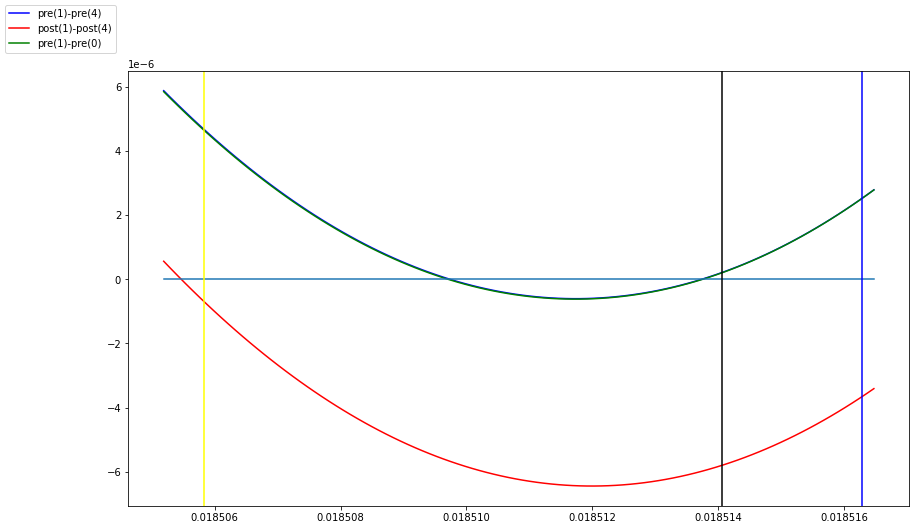

In [27]:
kk=54
rho = max(np.linalg.eig(A_pre(k=kk))[0])
rhop = max(np.linalg.eig(A_post(k=kk))[0])

xx = np.linspace(1/(kk+2.1/kk), (1/rho)*1.00001, 100)
yy = [r_pre[1](k=kk)(a=x) - r_pre[4](k=kk)(a=x) for x in xx]
zz = [r_post[1](k=kk)(a=x) - r_post[4](k=kk)(a=x) for x in xx]
tt = [r_pre[1](k=kk)(a=x) - r_pre[0](k=kk)(a=x) for x in xx]
fig = plt.pyplot.figure(figsize=(14,8))
plt.pyplot.plot(xx, yy, color = "blue", label = "pre(1)-pre(4)")
plt.pyplot.plot(xx, zz, color = "red", label = "post(1)-post(4)")
plt.pyplot.plot(xx, tt, color = "green", label = "pre(1)-pre(0)")
plt.pyplot.plot(xx, [0]*len(xx))
plt.pyplot.axvline(x = 1/rho, color = "blue")
plt.pyplot.axvline(x = 1/rhop, color = "black")
plt.pyplot.axvline(x = 1/(kk+2/kk), color = "yellow")
fig.legend(loc = "upper left")
fig.show()

Behavior of the relative importance of nodes 0, 1 and 4 in the interval where the importance flips happen.

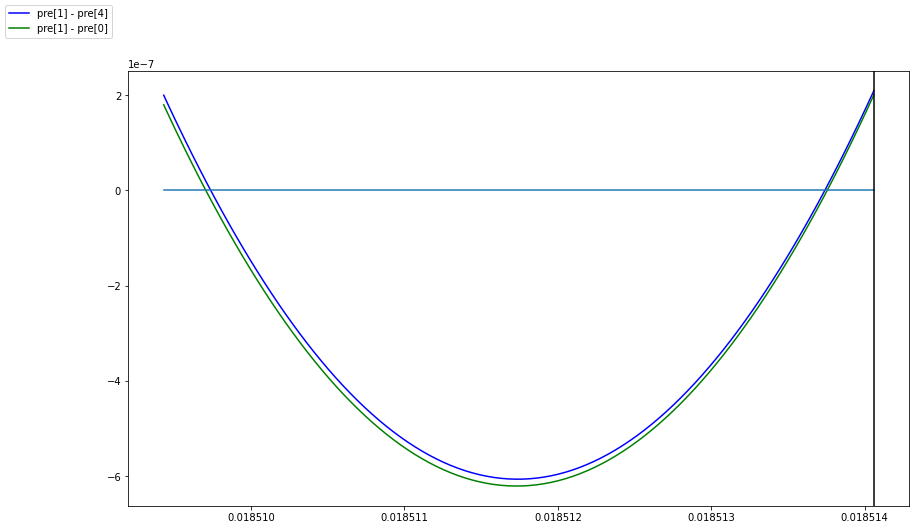

In [28]:
kk=54
rhop = max(np.linalg.eig(A_post(k=kk))[0])
xx = np.linspace(.99975/rhop, (1/rhop), 100)
yy = [r_pre[1](k=kk)(a=x) - r_pre[4](k=kk)(a=x) for x in xx]
tt = [r_pre[1](k=kk)(a=x) - r_pre[0](k=kk)(a=x) for x in xx]
fig = plt.pyplot.figure(figsize=(14,8))
plt.pyplot.plot(xx, yy, color = "blue", label = "pre[1] - pre[4]")
plt.pyplot.plot(xx, tt, color = "green", label = "pre[1] - pre[0]")
plt.pyplot.plot(xx, [0]*len(xx))
plt.pyplot.axvline(x = 1/rhop, color = "black")
fig.legend(loc = "upper left")
fig.show()